In [ ]:
'''
1. Import Packages
2. Import Data
3. Preproccess Data Frame:
    1. Remove rows that have N/A values in Market Category Column
    2. Convert 'Make', 'Market Category', 'Vehicle Size', 'Vehicle Style' 
       into Numerical Enumerations
    3. Normalize data (improves accuracy for calculating distance/Euclidean Distance)
4.  Run DBSCAN for 5 Dimensional feature set for 'Make', 'Year', 'Market Category', 'Vehicle Size', 'Vehicle Style'
5. Visualize/Plot Clusters
'''

In [1]:
# Import Packages
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import csv
import pandas as pd
%matplotlib inline

In [2]:
# Import Data
car_df = pd.read_csv('car_data.csv')
car_df.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
'''Preprocess Data'''

# Remove Spaces in Column Names
car_df = car_df.rename(columns={"Market Category": "Market_Category", "Vehicle Size": "Vehicle_Size", "Vehicle Style": "Vehicle_Style" })

# Drop rows
car_df.drop(car_df.index[car_df['Market_Category'] == 'N/A'], inplace=True)
# car_df = car_df[car_df.Market_Category != 'N/A']

In [4]:
# Convert Categorical columns to numeric
M_List = car_df.Make.unique()
MK_List = car_df.Market_Category.unique()
VZ_List = car_df.Vehicle_Size.unique()
VS_List = car_df.Vehicle_Style.unique()

car_df.Make = car_df['Make'].replace(M_List, range(len(M_List))) # for each unique category in column, replace with a number 0-(size of MList)
car_df.Market_Category = car_df['Market_Category'].replace(MK_List, range(len(MK_List)))
car_df.Vehicle_Size = car_df['Vehicle_Size'].replace(VZ_List, range(len(VZ_List)))
car_df.Vehicle_Style = car_df['Vehicle_Style'].replace(VS_List, range(len(VS_List)))

# alternatively could use pd.get_dummies() which will create a seperate column for each unique category, but to reduce dimension size we use replace method

In [5]:
# Reset index for dropped rows
car_df = car_df.reset_index(drop=True)

In [6]:
# Normalize Data
predictors = car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style']].values

predictors = preprocessing.StandardScaler().fit(predictors).transform(predictors.astype(float))
predictors[0:3]

array([[-1.77192037,  0.08122813, -1.02199787, -1.07110811, -1.30207652],
       [-1.77192037,  0.08122813, -0.93462644, -1.07110811, -1.01762854],
       [-1.77192037,  0.08122813, -0.84725501, -1.07110811, -1.30207652]])

In [7]:
# Build Model

# Random state ensures that the splits that you generate are reproducible
sklearn.utils.check_random_state(1000)

DB_Model = DBSCAN(eps=0.3, min_samples=10).fit(predictors)

# Create new column in dataframe to hold our target cluster labels
clusters = DB_Model.labels_
car_df["Cluster"] = clusters

# ignore noise (-1) in our cluster count
numOfClusters = len(set(clusters)) - (1 if -1 in clusters else 0)


car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']].head(5)

,Make,Year,Market_Category,Vehicle_Size,Vehicle_Style,Cluster
0,0,2011,0,0,0,0
1,0,2011,1,0,1,0
2,0,2011,2,0,0,0
3,0,2011,1,0,0,0
4,0,2011,3,0,1,0


In [44]:
# Save Model
import joblib

# pickle files serialize your ML algorithiim and save them in a serialized format to a file
# save
# joblib.dump(DB_Model, "Car_Cluster.pkl")

# using the joblib libray, you can deserialize pickle files to load your model
# load
# model = joblib.load("Car_Cluster.pkl")

# model.predict(X[0:1])

['Car_Cluster.pkl']

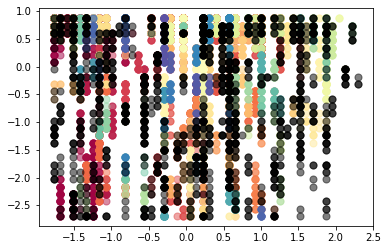

In [9]:
# Visualize Data

# create colors for each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(clusters)))) # sets the default colormap to spectral

# create an array of booleans using the labels from the model. This determines which data points belong to a cluster or outlier
core_samples_mask = np.zeros_like(DB_Model.labels_, dtype=bool) # create an array of zeros with the same shape as the Model's Labels, override type to bool
core_samples_mask[DB_Model.core_sample_indices_] = True  # get the indices of the core points/samples and set the indices in the masks at the location to ture

# Plot the points with colors
for k, col in zip(set(clusters), colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
    
    # create a mask for the cluster group corresponding to k (cluster label)
    class_member_mask = (clusters == k)

    # Plot the datapoints that are clustered
    xy = predictors[class_member_mask & core_samples_mask] # get our predictors where there is a cluster group AND the group belongs to a core cluster group
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5) # params: x, y, marker size, list of colors, marker type, alpha blending value for opacity when points overlap
    
    # Plot the outlier points (ones that may not belong to a cluster)
    xy = predictors[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [ ]:
# Validate work

In [10]:
len(set(clusters))

237

In [14]:
len(predictors[core_samples_mask & (clusters == 1)]) # count which are in cluster group 1 where there is also a core cluster
# Core_samples_mask is a 1D 11914 row array of T/F values whether each row/data point is a part of a core sample
# clusters is a 1D array of numerical labels, using clusters == 1 returns rows/data points that are in cluster 1, (T/F) values returned
# using the syntax above, we do not have to combine 'Cluster' column to predictors and can instead evaluate the current row/data point using a mask or 'filter'

151

In [18]:
len(predictors[~core_samples_mask & (clusters == 1)]) # count outliers that are in the cluster group but not close to core point
'''cluster 1 has 151 points but, near its cluster it has 6 outliers'''
'''cluster -1 is the only cluster set that has points that were not near any core points at all'''
'''consider "outliers" as border points instead'''

6

In [26]:
predictors.shape # the problem was our graph represented only 2 out of the 5 features, we have a 5 dimensional model, we were not passing all columns of xy[:,...]

(11914, 5)

In [7]:
# Replot in 3 Dimensions

def plot_cluster_3D(subPltRows, subPltCols, features):
    for i in range(len(features)): 
        dimPlt = plt.subplot(subPltRows,subPltCols,i+1, projection='3d') # rows, columns, location
        plt.figure(figsize=(10, 10))
        for k, col in zip(set(clusters), colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            class_member_mask = (clusters == k)

            xyz = predictors[class_member_mask & core_samples_mask]
            dimPlt.scatter3D(xyz[:, features[i][0]], xyz[:, features[i][1]], xyz[:, features[i][2]], s=50, c=[col], marker=u'o', alpha=0.5)
            # here features[][] represents the columns of our predictors, i.e. 1 ~ 'Year'
            
            xyz = predictors[class_member_mask & ~core_samples_mask]
            dimPlt.scatter3D(xyz[:, features[i][0]], xyz[:, features[i][1]], xyz[:, features[i][2]], s=25, c=[col], marker=u'o', alpha=0.5)

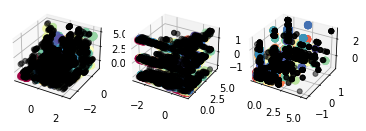

In [22]:
# Create sublots to view 3 Dimensional CLustered data

plot_cluster_3D(1,3, [[0,1,2],[1,2,3],[2,3,4]]) # to plot the rest of compinations nCr 5C3 you need 7 more feature set combinations

# Here we see there may be a strong relationship between 'Year', 'Market Category', and 'Vehicle Size', 
# but there is still a lot of noise and many clusters so let's optimize this further

In [16]:
# Determine Accuracy with Silhouette Coefficient
from sklearn import metrics
metrics.silhouette_score(car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df["Cluster"])

0.4227129780062382

In [23]:
# Adjust Minimum Samples based on dimensionality 2*dim
minPts = 2 * 5

In [64]:
# Adjust Epsilon
from sklearn.neighbors import NearestNeighbors

# To determine the best epsilon value, we calculate the average distance between each point and its closest/nearest neighbors, We then plot a k-distance and choose the epsilon value at the “elbow” of the graph see https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
dataSet = car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style']]
neighbors = NearestNeighbors(n_neighbors=5) # creates model to implement neighbor searches
neighbors_fit = neighbors.fit(dataSet) # fit our model using our data
distances, indices = neighbors_fit.kneighbors(dataSet) # return array of average distances of k-neighbors of each point in dataset

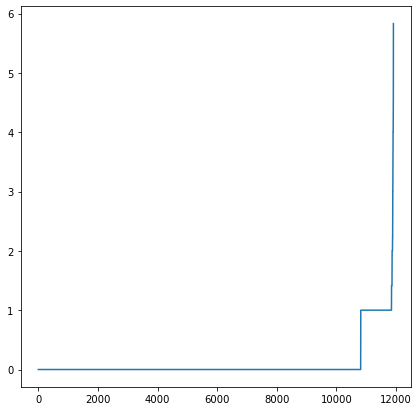

In [65]:
# Sort and plot average distances to find best epsilon
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(7, 7))
#plt.locator_params(axis="x", nbins=10)
#plt.locator_params(axis="y", nbins=15)
# or plt.yticks(np.arange(min(distances), max(distances)+1, 0.3))
plt.plot(distances)

In [24]:
# Build Model

def buildModel(e,minpts):
    sklearn.utils.check_random_state(1000)

    car_df2 = car_df # make a copy
    
    # Normalize Data
    predictors = car_df2[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style']].values
    predictors = preprocessing.StandardScaler().fit(predictors).transform(predictors.astype(float))
    
    DB_Model = DBSCAN(eps=e, min_samples=minpts).fit(predictors)

    # Create new column in dataframe to hold our target cluster labels
    clusters = DB_Model.labels_
    car_df2['Cluster'] = clusters

    # ignore noise (-1) in our cluster count
    numOfClusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    return DB_Model, numOfClusters, car_df2

In [9]:
# Visualize Data

def plotClusters(DB_Model, clusters, subPltRows, subPltCols, features):
    # create colors for each cluster
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(clusters))))

    # create an array of booleans using the labels from the model. This determines which data points belong to a cluster or outlier
    core_samples_mask = np.zeros_like(DB_Model.labels_, dtype=bool)
    core_samples_mask[DB_Model.core_sample_indices_] = True

    plot_cluster_3D(subPltRows, subPltCols, features)
    

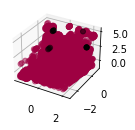

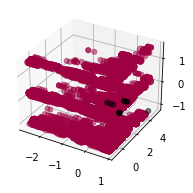

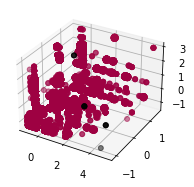

<Figure size 720x720 with 0 Axes>

In [52]:
# Try again with optimal epsilon estimate and minPts
db_model, clusters, car_df2 = buildModel(1.3,minPts)
plotClusters(db_model, clusters, 1,3, [[0,1,2],[1,2,3],[2,3,4]])

In [53]:
len(set(clusters))

5

In [ ]:
''' Our model is overfitting '''

In [55]:
# Get Accuracy
from sklearn import metrics
metrics.silhouette_score(car_df2[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df2["Cluster"])

0.2526591453127113

In [84]:
# Iterate through an interval of Eps and MinPts values to find best model (based on accuracy metric)

# judging by the elbow of our epsilon distance graph choose 10500 to 11500 as our interval for eps values
# for MinPts:
'''
- The larger the data set, the larger the value of MinPts should be.
- If the data set is noisier, choose a larger value of MinPts.
- Generally, MinPts should be greater than or equal to the dimensionality of the data set.
'''
params = []


for i in np.arange(0.1, 0.8, 0.03):
    for j in range(1, 20):
        db_model, clusters, car_df2 = buildModel(i,j)
        accuracy = metrics.silhouette_score(car_df2[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df2['Cluster'])
        params.append([i,j,accuracy])

print(params)

[[0.1, 1, 0.857743601280448], [0.1, 2, 0.8524080658380295], [0.1, 3, 0.7288046837151377], [0.1, 4, 0.6349364089041786], [0.1, 5, 0.49000490278628667], [0.1, 6, 0.4220165096356234], [0.1, 7, 0.31241300372905195], [0.1, 8, 0.25866132073212994], [0.1, 9, 0.1851951164701087], [0.1, 10, 0.14120232382741918], [0.1, 11, 0.10324063731725362], [0.1, 12, 0.09378441467464889], [0.1, 13, -3.311088028410582e-05], [0.1, 14, -0.10508692890760629], [0.1, 15, -0.1525102064396808], [0.1, 16, -0.18175309080395727], [0.1, 17, -0.23293528661158755], [0.1, 18, -0.3363398706582705], [0.1, 19, -0.3578239238385713], [0.13, 1, 0.8452762141891926], [0.13, 2, 0.8400867520262442], [0.13, 3, 0.7193825586376454], [0.13, 4, 0.6256589847678694], [0.13, 5, 0.48989116368037683], [0.13, 6, 0.4168056294217224], [0.13, 7, 0.3259136427751051], [0.13, 8, 0.2737771379956777], [0.13, 9, 0.21601703131963385], [0.13, 10, 0.17221963297132], [0.13, 11, 0.12956637169922464], [0.13, 12, 0.11392517478620118], [0.13, 13, 0.05229619691

In [86]:
sorted_params = sorted(params, key=lambda x: x[2]) # sort our observations by accuracy
# key set to a lambda function of syntax lambda x: x[i] to sort a multidimensional list iterable by the ith element in each inner list x

best_params = sorted_params[-1] # get last element, which is the set with our maximum accuracy
# The list[-n] syntax gets the nth-to-last element.

best_params

[0.1, 1, 0.857743601280448]

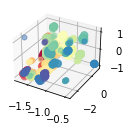

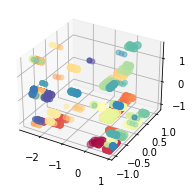

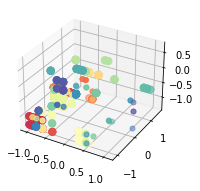

<Figure size 720x720 with 0 Axes>

In [87]:
# Try again with optimal epsilon estimate and minPts
db_model, clusters, car_df2 = buildModel(best_params[0],best_params[1])
plotClusters(db_model, clusters, 1,3, [[0,1,2],[1,2,3],[2,3,4]])

In [91]:
len(set(clusters))

3041

In [ ]:
''' Our model is still underfitting '''

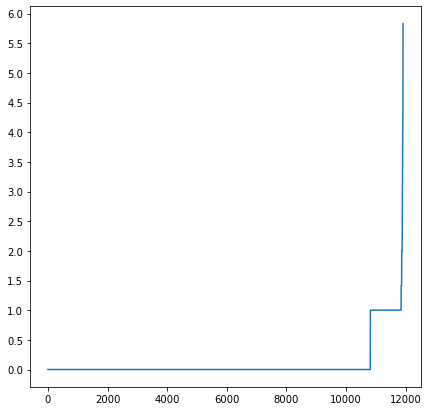

In [11]:
# Let's use a higher value for our K-nearest neighbors model in order to find eps
from sklearn.neighbors import NearestNeighbors

dataSet = car_df[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style']]
neighbors = NearestNeighbors(n_neighbors=10) # use minPts for nearest neighbors
neighbors_fit = neighbors.fit(dataSet)
distances, indices = neighbors_fit.kneighbors(dataSet)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(7, 7))
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=15)
plt.plot(distances)

In [12]:
distances[11820:11900]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.73205081, 1.73205081, 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.        , 2.        , 2.        ,
       2.        , 2.        , 2.23606798, 2.23606798, 2.23606798,
       2.23606798, 2.23606798, 2.23606798, 2.64575131, 2.64575131,
       2.64575131, 3.        , 3.        , 3.        , 3.16227

In [39]:
# Try values slightly above and below optimal params

from sklearn import metrics

epsRange = distances[11850:11880]
params = []

for i in epsRange:
    for j in range(8, 12):
        db_model, numOfClusters, car_df2 = buildModel(i,j)
        accuracy = metrics.silhouette_score(car_df2[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df2['Cluster'])
        params.append([i,j,accuracy])

print(params)

[[1.4142135623730951, 8, 0.24438394721397552], [1.4142135623730951, 9, 0.24438394721397552], [1.4142135623730951, 10, 0.24438394721397552], [1.4142135623730951, 11, 0.24438394721397552], [1.4142135623730951, 8, 0.24438394721397552], [1.4142135623730951, 9, 0.24438394721397552], [1.4142135623730951, 10, 0.24438394721397552], [1.4142135623730951, 11, 0.24438394721397552], [1.4142135623730951, 8, 0.24438394721397552], [1.4142135623730951, 9, 0.24438394721397552], [1.4142135623730951, 10, 0.24438394721397552], [1.4142135623730951, 11, 0.24438394721397552], [1.4142135623730951, 8, 0.24438394721397552], [1.4142135623730951, 9, 0.24438394721397552], [1.4142135623730951, 10, 0.24438394721397552], [1.4142135623730951, 11, 0.24438394721397552], [1.4142135623730951, 8, 0.24438394721397552], [1.4142135623730951, 9, 0.24438394721397552], [1.4142135623730951, 10, 0.24438394721397552], [1.4142135623730951, 11, 0.24438394721397552], [1.4142135623730951, 8, 0.24438394721397552], [1.4142135623730951, 9,

In [38]:
from sklearn import metrics

epsRange = distances[11900]
params = []

db_model, numOfClusters, car_df2 = buildModel(1.73,10)

accuracy = metrics.silhouette_score(car_df2[['Make', 'Year', 'Market_Category', 'Vehicle_Size', 'Vehicle_Style', 'Cluster']], car_df2['Cluster'])
params.append([accuracy])

print(params,numOfClusters)

[[0.243387572760202]] 3
